# Practical Work

<b> Student: </b> Jonas Fallmann <br>
<b> Matrikulation number </b> 12018700 <br>
<b> Topic:</b> Evaulating gender bias of explained recommender systems<br>
<b> Institute: </b> Institute of Computational Perception, Johannes Kepler University Linz

## Outline
Recent advances in the field of recommender systems focus in a big part on explanations of recommended Items. Explainability has been shown to aid user trust and results in higher conversion rates in the online shopping domain. As an example, explanations in the music domain could be of the following form:

<b>Recommended Item:</b> Clocks and Whoopty by Pintel Ragetti<br>
<b> Explanation: </b>  



# Train Model

### Load config and create Dataset

In [1]:
from logging import getLogger
from recbole.config import Config
from recbole.data import create_dataset, data_preparation
from recbole.model.knowledge_aware_recommender import KGAT
from recbole.trainer import KGATTrainer
from recbole.utils import init_seed, init_logger

train_model = True
create_paths = True

In [2]:

# configurations initialization
config = Config(model='KGAT', dataset='rb_lfm', config_file_list=['lfm.yaml'])

# init random seed
init_seed(config['seed'], config['reproducibility'])

# logger initialization
init_logger(config)
logger = getLogger()

# write config info into log
logger.info(config)

# dataset creating and filtering
dataset = create_dataset(config)
logger.info(dataset)

# dataset splitting
train_data, valid_data, test_data = data_preparation(config, dataset)


27 Feb 14:19    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = ./data/rb_lfm
checkpoint_dir = saved
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = False

Training Hyper Parameters:
epochs = 20
train_batch_size = 512
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'uniform', 'sample_num': 1, 'alpha': 1.0, 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [8, 1, 1]}, 'group_by': 'user', 'order': 'RO', 'mode': 'full'}
repeatable = False
metrics = ['NDCG', 'Hit', 'Precision']
topk = [10]
valid_metric = NDCG@10
valid_metric_bigger = True
eval_batch_size = 256
metric_decimal_place = 4

Dataset Hyper Parameters:
field_separator = 	
seq_separator =  
USER_ID_FIELD = u

### Train model and evaluate

In [3]:
if train_model:
    # model loading and initialization
    model = KGAT(config, train_data._dataset).to(config['device'])
    logger.info(model)

    # trainer loading and initialization
    trainer = KGATTrainer(config, model)

    print('Starting to fit model')
    # model training
    best_valid_score, best_valid_result = trainer.fit(train_data, valid_data, saved=True, show_progress=True)

    print('Evaluating model')
    # model evaluation
    test_result = trainer.evaluate(test_data, load_best_model=True)
    print(test_result)

/home/jfallmann/miniconda3/envs/pr/lib/python3.9/site-packages/dgl/subgraph.py:288: DGLWarning: Key word argument preserve_nodes is deprecated. Use relabel_nodes instead.
  dgl_warning(
/home/jfallmann/miniconda3/envs/pr/lib/python3.9/site-packages/recbole/model/knowledge_aware_recommender/kgat.py:159: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -1).flatten()
/home/jfallmann/miniconda3/envs/pr/lib/python3.9/site-packages/recbole/model/knowledge_aware_recommender/kgat.py:166: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/torch/csrc/utils/tensor_new.cpp:230.)
  indices = torch.LongTensor([final_adj_matrix.row, final_adj_matrix.col])
27 Feb 14:20    INFO  KGAT(
  (user_embedding): Embedding(9569, 32)
  (entity_embedding): Embedding(173441,

Starting to fit model


Train     0:   0%|          | 0/7128 [00:00<?, ?it/s]

Train     0:   0%|          | 0/2976 [00:00<?, ?it/s]

27 Feb 14:39    INFO  epoch 0 training [time: 1177.89s, train_loss1: 2137.8465, train_loss2: 161.5594]


Evaluate   :   0%|                                                         | 0/9531 [00:00<?, ?it/s…

27 Feb 14:40    INFO  epoch 0 evaluating [time: 18.54s, valid_score: 0.052600]
27 Feb 14:40    INFO  valid result: 
ndcg@10 : 0.0526    hit@10 : 0.2669    precision@10 : 0.0465
27 Feb 14:40    INFO  Saving current: saved/KGAT-Feb-27-2023_14-20-18.pth


Train     1:   0%|          | 0/7128 [00:00<?, ?it/s]

Train     1:   0%|          | 0/2976 [00:00<?, ?it/s]

27 Feb 14:54    INFO  epoch 1 training [time: 858.60s, train_loss1: 1835.3998, train_loss2: 41.2298]


Evaluate   :   0%|                                                         | 0/9531 [00:00<?, ?it/s…

27 Feb 14:54    INFO  epoch 1 evaluating [time: 18.30s, valid_score: 0.086300]
27 Feb 14:54    INFO  valid result: 
ndcg@10 : 0.0863    hit@10 : 0.3638    precision@10 : 0.0747
27 Feb 14:54    INFO  Saving current: saved/KGAT-Feb-27-2023_14-20-18.pth


Train     2:   0%|          | 0/7128 [00:00<?, ?it/s]

Train     2:   0%|          | 0/2976 [00:00<?, ?it/s]

27 Feb 15:09    INFO  epoch 2 training [time: 856.35s, train_loss1: 1280.8120, train_loss2: 22.8692]


Evaluate   :   0%|                                                         | 0/9531 [00:00<?, ?it/s…

27 Feb 15:09    INFO  epoch 2 evaluating [time: 17.92s, valid_score: 0.092000]
27 Feb 15:09    INFO  valid result: 
ndcg@10 : 0.092    hit@10 : 0.3797    precision@10 : 0.0799
27 Feb 15:09    INFO  Saving current: saved/KGAT-Feb-27-2023_14-20-18.pth


Train     3:   0%|          | 0/7128 [00:00<?, ?it/s]

Train     3:   0%|          | 0/2976 [00:00<?, ?it/s]

27 Feb 15:23    INFO  epoch 3 training [time: 830.66s, train_loss1: 1013.9281, train_loss2: 15.1526]


Evaluate   :   0%|                                                         | 0/9531 [00:00<?, ?it/s…

27 Feb 15:23    INFO  epoch 3 evaluating [time: 17.22s, valid_score: 0.095500]
27 Feb 15:23    INFO  valid result: 
ndcg@10 : 0.0955    hit@10 : 0.3881    precision@10 : 0.083
27 Feb 15:23    INFO  Saving current: saved/KGAT-Feb-27-2023_14-20-18.pth


Train     4:   0%|          | 0/7128 [00:00<?, ?it/s]

Train     4:   0%|          | 0/2976 [00:00<?, ?it/s]

27 Feb 15:37    INFO  epoch 4 training [time: 822.87s, train_loss1: 850.7247, train_loss2: 11.3744]


Evaluate   :   0%|                                                         | 0/9531 [00:00<?, ?it/s…

27 Feb 15:37    INFO  epoch 4 evaluating [time: 18.08s, valid_score: 0.100300]
27 Feb 15:37    INFO  valid result: 
ndcg@10 : 0.1003    hit@10 : 0.3988    precision@10 : 0.0871
27 Feb 15:37    INFO  Saving current: saved/KGAT-Feb-27-2023_14-20-18.pth


Train     5:   0%|          | 0/7128 [00:00<?, ?it/s]

Train     5:   0%|          | 0/2976 [00:00<?, ?it/s]

27 Feb 15:51    INFO  epoch 5 training [time: 857.44s, train_loss1: 739.3235, train_loss2: 9.0457]


Evaluate   :   0%|                                                         | 0/9531 [00:00<?, ?it/s…

27 Feb 15:52    INFO  epoch 5 evaluating [time: 18.06s, valid_score: 0.103500]
27 Feb 15:52    INFO  valid result: 
ndcg@10 : 0.1035    hit@10 : 0.41    precision@10 : 0.0897
27 Feb 15:52    INFO  Saving current: saved/KGAT-Feb-27-2023_14-20-18.pth


Train     6:   0%|          | 0/7128 [00:00<?, ?it/s]

Train     6:   0%|          | 0/2976 [00:00<?, ?it/s]

27 Feb 16:06    INFO  epoch 6 training [time: 857.44s, train_loss1: 655.6998, train_loss2: 7.2053]


Evaluate   :   0%|                                                         | 0/9531 [00:00<?, ?it/s…

27 Feb 16:06    INFO  epoch 6 evaluating [time: 18.20s, valid_score: 0.105300]
27 Feb 16:06    INFO  valid result: 
ndcg@10 : 0.1053    hit@10 : 0.4098    precision@10 : 0.092
27 Feb 16:06    INFO  Saving current: saved/KGAT-Feb-27-2023_14-20-18.pth


Train     7:   0%|          | 0/7128 [00:00<?, ?it/s]

Train     7:   0%|          | 0/2976 [00:00<?, ?it/s]

27 Feb 16:20    INFO  epoch 7 training [time: 836.77s, train_loss1: 593.1651, train_loss2: 6.3096]


Evaluate   :   0%|                                                         | 0/9531 [00:00<?, ?it/s…

27 Feb 16:21    INFO  epoch 7 evaluating [time: 18.15s, valid_score: 0.109500]
27 Feb 16:21    INFO  valid result: 
ndcg@10 : 0.1095    hit@10 : 0.4259    precision@10 : 0.096
27 Feb 16:21    INFO  Saving current: saved/KGAT-Feb-27-2023_14-20-18.pth


Train     8:   0%|          | 0/7128 [00:00<?, ?it/s]

Train     8:   0%|          | 0/2976 [00:00<?, ?it/s]

27 Feb 16:35    INFO  epoch 8 training [time: 858.23s, train_loss1: 538.5657, train_loss2: 5.4916]


Evaluate   :   0%|                                                         | 0/9531 [00:00<?, ?it/s…

27 Feb 16:35    INFO  epoch 8 evaluating [time: 18.25s, valid_score: 0.112300]
27 Feb 16:35    INFO  valid result: 
ndcg@10 : 0.1123    hit@10 : 0.4306    precision@10 : 0.0984
27 Feb 16:35    INFO  Saving current: saved/KGAT-Feb-27-2023_14-20-18.pth


Train     9:   0%|          | 0/7128 [00:00<?, ?it/s]

Train     9:   0%|          | 0/2976 [00:00<?, ?it/s]

27 Feb 16:49    INFO  epoch 9 training [time: 839.30s, train_loss1: 494.4193, train_loss2: 4.9667]


Evaluate   :   0%|                                                         | 0/9531 [00:00<?, ?it/s…

27 Feb 16:49    INFO  epoch 9 evaluating [time: 17.01s, valid_score: 0.116100]
27 Feb 16:49    INFO  valid result: 
ndcg@10 : 0.1161    hit@10 : 0.4408    precision@10 : 0.1019
27 Feb 16:49    INFO  Saving current: saved/KGAT-Feb-27-2023_14-20-18.pth


Train    10:   0%|          | 0/7128 [00:00<?, ?it/s]

Train    10:   0%|          | 0/2976 [00:00<?, ?it/s]

27 Feb 17:03    INFO  epoch 10 training [time: 813.58s, train_loss1: 458.1735, train_loss2: 4.5074]


Evaluate   :   0%|                                                         | 0/9531 [00:00<?, ?it/s…

27 Feb 17:03    INFO  epoch 10 evaluating [time: 17.08s, valid_score: 0.118300]
27 Feb 17:03    INFO  valid result: 
ndcg@10 : 0.1183    hit@10 : 0.4425    precision@10 : 0.104
27 Feb 17:03    INFO  Saving current: saved/KGAT-Feb-27-2023_14-20-18.pth


Train    11:   0%|          | 0/7128 [00:00<?, ?it/s]

Train    11:   0%|          | 0/2976 [00:00<?, ?it/s]

27 Feb 17:18    INFO  epoch 11 training [time: 853.70s, train_loss1: 430.9889, train_loss2: 4.3036]


Evaluate   :   0%|                                                         | 0/9531 [00:00<?, ?it/s…

27 Feb 17:18    INFO  epoch 11 evaluating [time: 18.56s, valid_score: 0.120800]
27 Feb 17:18    INFO  valid result: 
ndcg@10 : 0.1208    hit@10 : 0.452    precision@10 : 0.1061
27 Feb 17:18    INFO  Saving current: saved/KGAT-Feb-27-2023_14-20-18.pth


Train    12:   0%|          | 0/7128 [00:00<?, ?it/s]

Train    12:   0%|          | 0/2976 [00:00<?, ?it/s]

27 Feb 17:32    INFO  epoch 12 training [time: 856.99s, train_loss1: 402.0915, train_loss2: 4.0418]


Evaluate   :   0%|                                                         | 0/9531 [00:00<?, ?it/s…

27 Feb 17:32    INFO  epoch 12 evaluating [time: 18.33s, valid_score: 0.124100]
27 Feb 17:32    INFO  valid result: 
ndcg@10 : 0.1241    hit@10 : 0.4602    precision@10 : 0.1093
27 Feb 17:32    INFO  Saving current: saved/KGAT-Feb-27-2023_14-20-18.pth


Train    13:   0%|          | 0/7128 [00:00<?, ?it/s]

Train    13:   0%|          | 0/2976 [00:00<?, ?it/s]

27 Feb 17:47    INFO  epoch 13 training [time: 855.91s, train_loss1: 382.8423, train_loss2: 3.8520]


Evaluate   :   0%|                                                         | 0/9531 [00:00<?, ?it/s…

27 Feb 17:47    INFO  epoch 13 evaluating [time: 18.19s, valid_score: 0.127000]
27 Feb 17:47    INFO  valid result: 
ndcg@10 : 0.127    hit@10 : 0.4689    precision@10 : 0.1122
27 Feb 17:47    INFO  Saving current: saved/KGAT-Feb-27-2023_14-20-18.pth


Train    14:   0%|          | 0/7128 [00:00<?, ?it/s]

Train    14:   0%|          | 0/2976 [00:00<?, ?it/s]

27 Feb 18:01    INFO  epoch 14 training [time: 857.47s, train_loss1: 365.3161, train_loss2: 3.5052]


Evaluate   :   0%|                                                         | 0/9531 [00:00<?, ?it/s…

27 Feb 18:02    INFO  epoch 14 evaluating [time: 17.92s, valid_score: 0.128500]
27 Feb 18:02    INFO  valid result: 
ndcg@10 : 0.1285    hit@10 : 0.4695    precision@10 : 0.1128
27 Feb 18:02    INFO  Saving current: saved/KGAT-Feb-27-2023_14-20-18.pth


Train    15:   0%|          | 0/7128 [00:00<?, ?it/s]

Train    15:   0%|          | 0/2976 [00:00<?, ?it/s]

27 Feb 18:16    INFO  epoch 15 training [time: 857.68s, train_loss1: 349.2621, train_loss2: 3.6199]


Evaluate   :   0%|                                                         | 0/9531 [00:00<?, ?it/s…

27 Feb 18:16    INFO  epoch 15 evaluating [time: 18.28s, valid_score: 0.130800]
27 Feb 18:16    INFO  valid result: 
ndcg@10 : 0.1308    hit@10 : 0.4746    precision@10 : 0.1159
27 Feb 18:16    INFO  Saving current: saved/KGAT-Feb-27-2023_14-20-18.pth


Train    16:   0%|          | 0/7128 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Load best model

In [4]:
import os
import torch

In [7]:
latest_model = 'saved/%s' % os.listdir('saved')[-2]

In [8]:
latest_model

'saved/KGAT-Feb-27-2023_14-20-18.pth'

In [9]:
state_dict = torch.load(latest_model, map_location='cuda')
model = KGAT(config, train_data._dataset).to(config['device'])

model.load_state_dict(state_dict['state_dict'])

<All keys matched successfully>

In [10]:
trainer = KGATTrainer(config, model)
test_result = trainer.evaluate(test_data, load_best_model=False)
print(test_result)

OrderedDict([('ndcg@10', 0.1233), ('hit@10', 0.4653), ('precision@10', 0.1091)])


# Prepare for model evaluation

## Create graph from attention matrix

In [11]:
import os
import torch
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import shortest_path
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from recbole.data.interaction import Interaction


In [12]:
def get_path(Pr, j):
    path = [j]
    k = j
    while Pr[k] != -9999:
        path.append(Pr[k])
        k = Pr[k]
    return path[::-1]

In [13]:
from enum import Enum
class DistanceMode(Enum):
    Inverse=1
    RBF=2
    Linear=3

In [14]:
attention_matrix = model.A_in.cpu().coalesce()
attention_matrix_size = attention_matrix.size()[0] # since it is square

In [15]:
def create_scipy_matrix(distance_mode: str, size: int):
    attention_values = attention_matrix.values().numpy()
    if distance_mode == DistanceMode.Inverse:
        attention_values = 1/attention_values
    if distance_mode == DistanceMode.RBF:
        attention_values = np.exp(-attention_values**2)
    if distance_mode == DistanceMode.Linear:
        attention_values = 1-attention_values
    return coo_matrix((attention_values, (attention_matrix.indices()[0].numpy(), attention_matrix.indices()[1].numpy())), shape=(size,size))

In [16]:
graph_matrix = create_scipy_matrix(DistanceMode.RBF, attention_matrix_size)

## Create shortest path for k top predictions

<b> Important note:</b> Id's in the attention matrix are shiftet by the number of users `dataset.user_num`. So fetching an id using the token i.e. token2id results in an id not yet shifted. So to get the corresponding attention-matrix-id we need to shift items and entities!

In [17]:
k = 10

In [18]:
historical_interactions, interaction_mask, interaction_counts = dataset.history_item_matrix()
historical_interactions = historical_interactions.cpu().numpy()
interaction_mask = interaction_mask.cpu().numpy()
interaction_counts = interaction_counts.cpu().numpy()

In [19]:
valid_user_ids = np.arange(1, dataset.user_num)

In [20]:
model.eval()
user_paths = {}
if create_paths:
    for user_id in tqdm(valid_user_ids):
        interaction = Interaction({
            'user_id': torch.tensor([user_id])
        })
        predictions = model.full_sort_predict(interaction).detach().cpu().numpy()

        # calculate top 10 recommended items
        recommended_items = np.argsort(predictions)
        seen_items = np.unique(historical_interactions[user_id][:interaction_counts[user_id]])
        recommended_items = recommended_items[np.isin(recommended_items, seen_items, invert=True)]

        top_k_recommended_items = np.flip(recommended_items)[:k]

        # item ids in the entity list start after the users, 
        # so we have to add the number of users to the recommended indices
        top_k_recommended_items = top_k_recommended_items + dataset.user_num

        # now calculate shortest distances for current user
        shortest_distances, predecessors = shortest_path(graph_matrix, directed=True,  return_predecessors = True, indices=[user_id])

        # calculate the paths for the top k recommended items
        paths = []
        for item_idx in top_k_recommended_items:
            path = get_path(predecessors[0], item_idx)
            paths.append(np.asarray(path, dtype=int))
        user_paths[user_id] = paths

  0%|          | 0/9568 [00:00<?, ?it/s]

In [21]:
import pickle
file_name = 'paths.pkl'
if create_paths:
    with open(file_name, 'wb') as file:
        pickle.dump(user_paths, file)
        print(f'Object successfully saved to "{file_name}"')
else:
    with open(file_name, 'rb') as file:
        user_paths = pickle.load(file)
        print(f'Object successfully loaded from "{file_name}"')

Object successfully saved to "paths.pkl"


In [60]:
gender_ids = dataset.token2id('entity_id', ['m', 'f'])

In [64]:
male_attention_row = np.asarray(graph_matrix.getrow(dataset.user_num + gender_ids[0]).todense())
male_attention_row

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [65]:
np.nonzero(male_attention_row)

(array([], dtype=int64), array([], dtype=int64))

In [66]:
male_attention_col = np.asarray(graph_matrix.getcol(dataset.user_num + gender_ids[0]).todense())
male_attention_col

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [67]:
np.nonzero(male_attention_col)

(array([103757, 103758, 103759, ..., 113346, 113348, 113349]),
 array([0, 0, 0, ..., 0, 0, 0]))

## Load all users and divide into male and female

In [68]:
import pandas as pd
user_df = pd.read_csv('data/lfm/50percent_subset_users.tsv', sep='\t')

In [78]:
external_user_ids = [int(item) for item in dataset.id2token(dataset.uid_field, valid_user_ids)]

In [81]:
# remove users that recbole removed in the dataset creation process
user_df = user_df[user_df.user_id.isin(external_user_ids)]

In [82]:
male_users = user_df[user_df.gender == 'm']
female_users = user_df[user_df.gender =='f']

<BarContainer object of 2 artists>

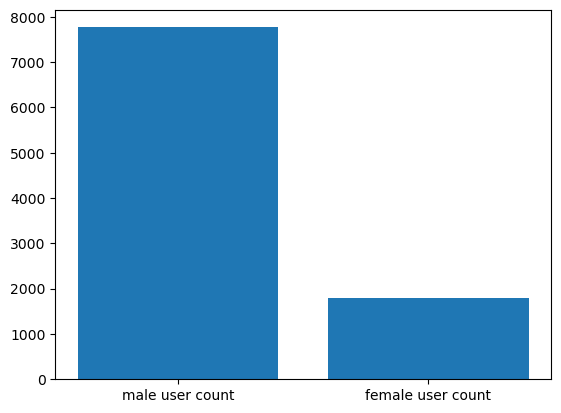

In [85]:
plt.bar(['male user count', 'female user count'], [len(male_users), len(female_users)])

In [102]:
male_internal_user_ids = dataset.token2id(dataset.uid_field, [str(item) for item in male_users.user_id.to_numpy()])
female_internal_user_ids = dataset.token2id(dataset.uid_field, [str(item) for item in female_users.user_id.to_numpy()])

In [109]:
male_paths = {}
for key in user_paths.keys():
    if key in male_internal_user_ids:
        male_paths[key] = user_paths[key]

female_paths = {}
for key in user_paths.keys():
    if key in female_internal_user_ids:
        female_paths[key] = user_paths[key]

In [128]:
def average_path_length(paths: dict):
    flat_list = [item for sublist in list(paths.values()) for item in sublist]
    lengths = [len(item) for item in flat_list]
    return np.mean(lengths), lengths

In [129]:
male_average, male_lengths = average_path_length(male_paths)

In [130]:
female_average, female_lengths = average_path_length(female_paths)

<BarContainer object of 2 artists>

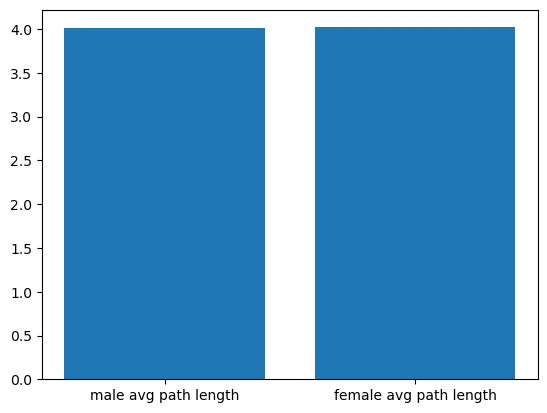

In [137]:
plt.bar(['male avg path length', 'female avg path length'], [male_average, female_average])

(array([7.7092e+04, 0.0000e+00, 5.9400e+02, 0.0000e+00, 1.4000e+01,
        0.0000e+00]),
 array([ 4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 6 artists>)

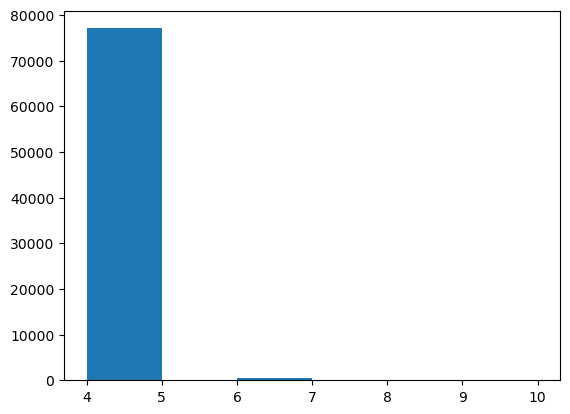

In [135]:
plt.hist(male_lengths, bins=[4,5,6,7,8,9,10])

(array([1.7803e+04, 0.0000e+00, 1.6800e+02, 0.0000e+00, 8.0000e+00,
        1.0000e+00]),
 array([ 4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 6 artists>)

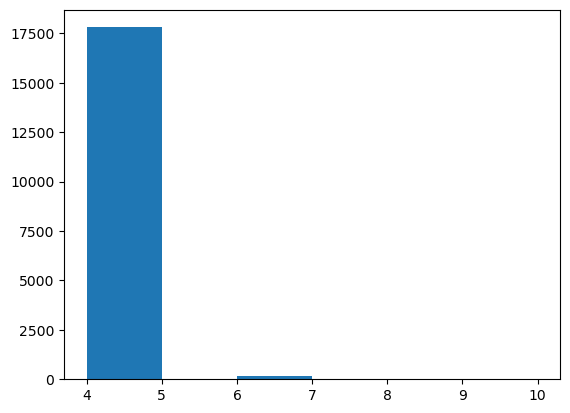

In [136]:
plt.hist(female_lengths, bins=[4,5,6,7,8,9,10])